In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import numpy as np
import scipy as sp
from matplotlib import gridspec as mpgs
from skimage import transform as skt
import os
from scipy import ndimage as scnd
import hdf5storage as h5
from matplotlib_scalebar.scalebar import ScaleBar,SI_LENGTH_RECIPROCAL
from matplotlib.offsetbox import AnchoredText
import math
import numba
import pyfftw
import stemtool as st
import dask
from dask.distributed import Client
from dask import delayed, compute
import dask.array as da
%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'bold'})

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
st.tic()
datRhPt = h5.loadmat('/home/cades/Data4D_2/Debangshu/Core@Shell NBED/Nion Swift Library 20190810 - EH-83-I Rh@Pt Thick/RhPtThick.mat')
st.toc()

Elapsed time: 35.323004 seconds.



In [4]:
st.tic()
json1 = '/home/cades/Data4D_2/Debangshu/Core@Shell NBED/Nion Swift Library 20190810 - EH-83-I Rh@Pt Thick/Particle1_ACSTEM_00.json'
json2 = '/home/cades/Data4D_2/Debangshu/Core@Shell NBED/Nion Swift Library 20190810 - EH-83-I Rh@Pt Thick/Particle2_ACSTEM_00.json'
with open(json1) as json_1:
    info_1 = json.load(json_1)
with open(json2) as json_2:
    info_2 = json.load(json_2)
st.toc()

Elapsed time: 0.001579 seconds.



In [5]:
calib1 = info_1['spatial_calibrations'][0]['scale']
calib1_units = info_1['spatial_calibrations'][0]['units']

In [6]:
imageDC = datRhPt['particle1_im']

To ensure only the nanoparticle is picked, we will do a digital selected area electron diffraction - we will pick two diffraction spots and then mask the image so that we will analyze only the image where the diffraction spots came from.

In [7]:
imageDC.shape

(1970, 1970)

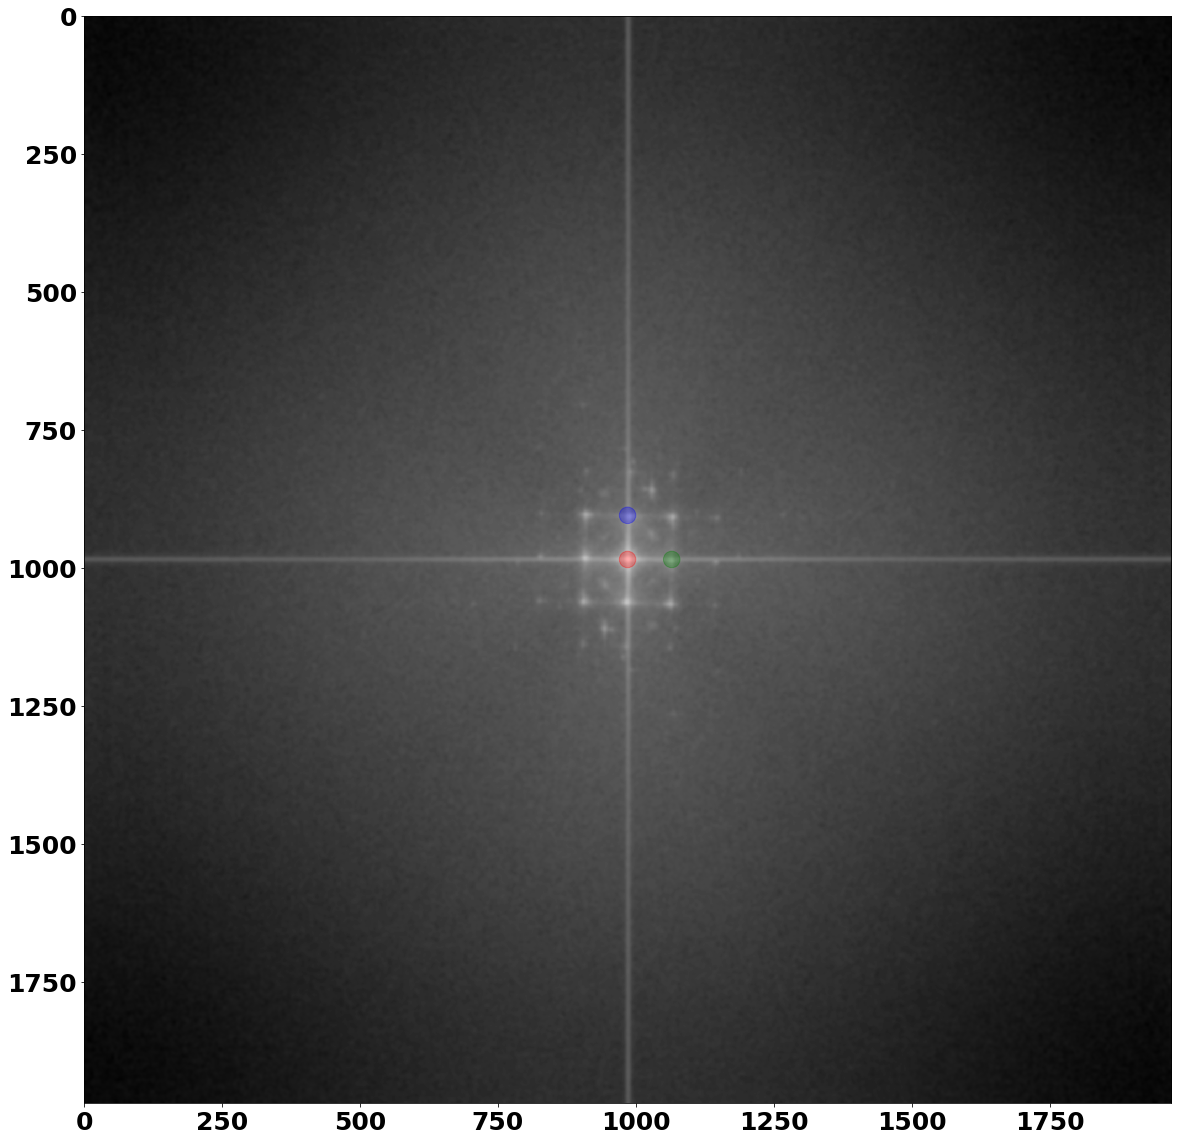

In [8]:
st.afit.find_diffraction_spots(image=imageDC,
                               circ_c=(985,985),
                               circ_y=(985,905),
                               circ_x=(1065,985))

In [9]:
st.tic()
imDC_000, ftDC_000, centerDC_000, maskDC_000 = st.afit.fourier_mask(imageDC,(985,985),30,0.1)
imDC_020, ftDC_020, centerDC_020, maskDC_020 = st.afit.fourier_mask(imageDC,(985,905),30,0.1)
imDC_200, ftDC_200, centerDC_200, maskDC_200 = st.afit.fourier_mask(imageDC,(1065,985),30,0.1)
st.toc()

Elapsed time: 10.427603 seconds.



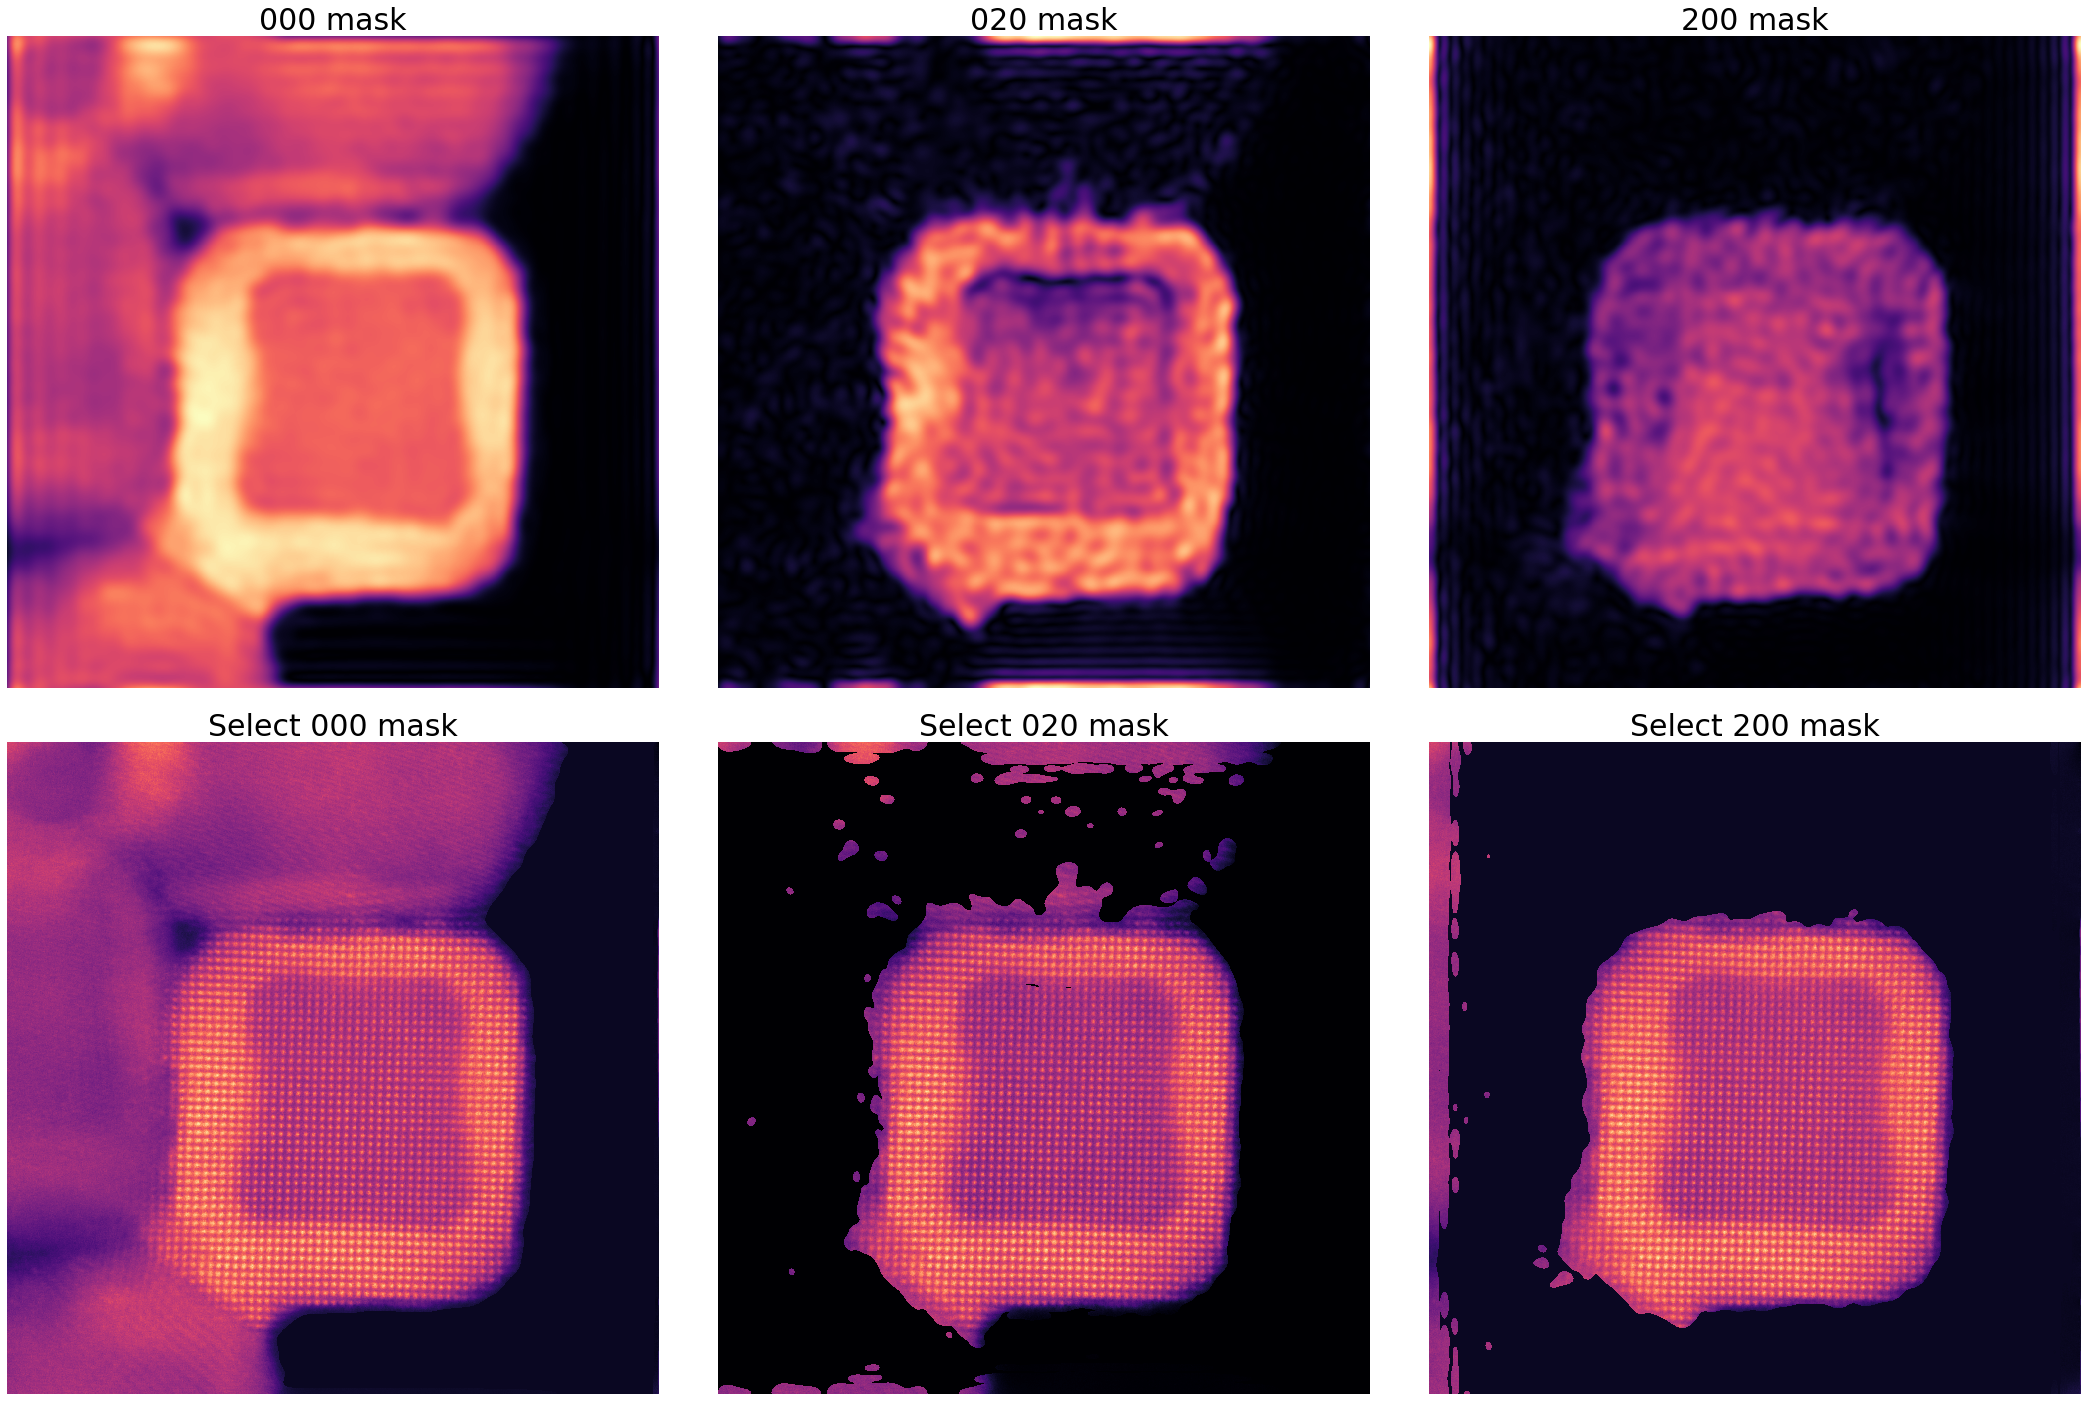

In [10]:
plt.figure(figsize=(30, 20))
plt.subplot(2,3,1)
plt.imshow(np.abs(ftDC_000))
plt.title('000 mask')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(np.abs(ftDC_020))
plt.title('020 mask')
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(np.abs(ftDC_200))
plt.title('200 mask')
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(imDC_000)
plt.title('Select 000 mask')
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(imDC_020)
plt.title('Select 020 mask')
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(imDC_200)
plt.title('Select 200 mask')
plt.axis('off')

plt.tight_layout()

We will go with the outcome of the 200 mask.

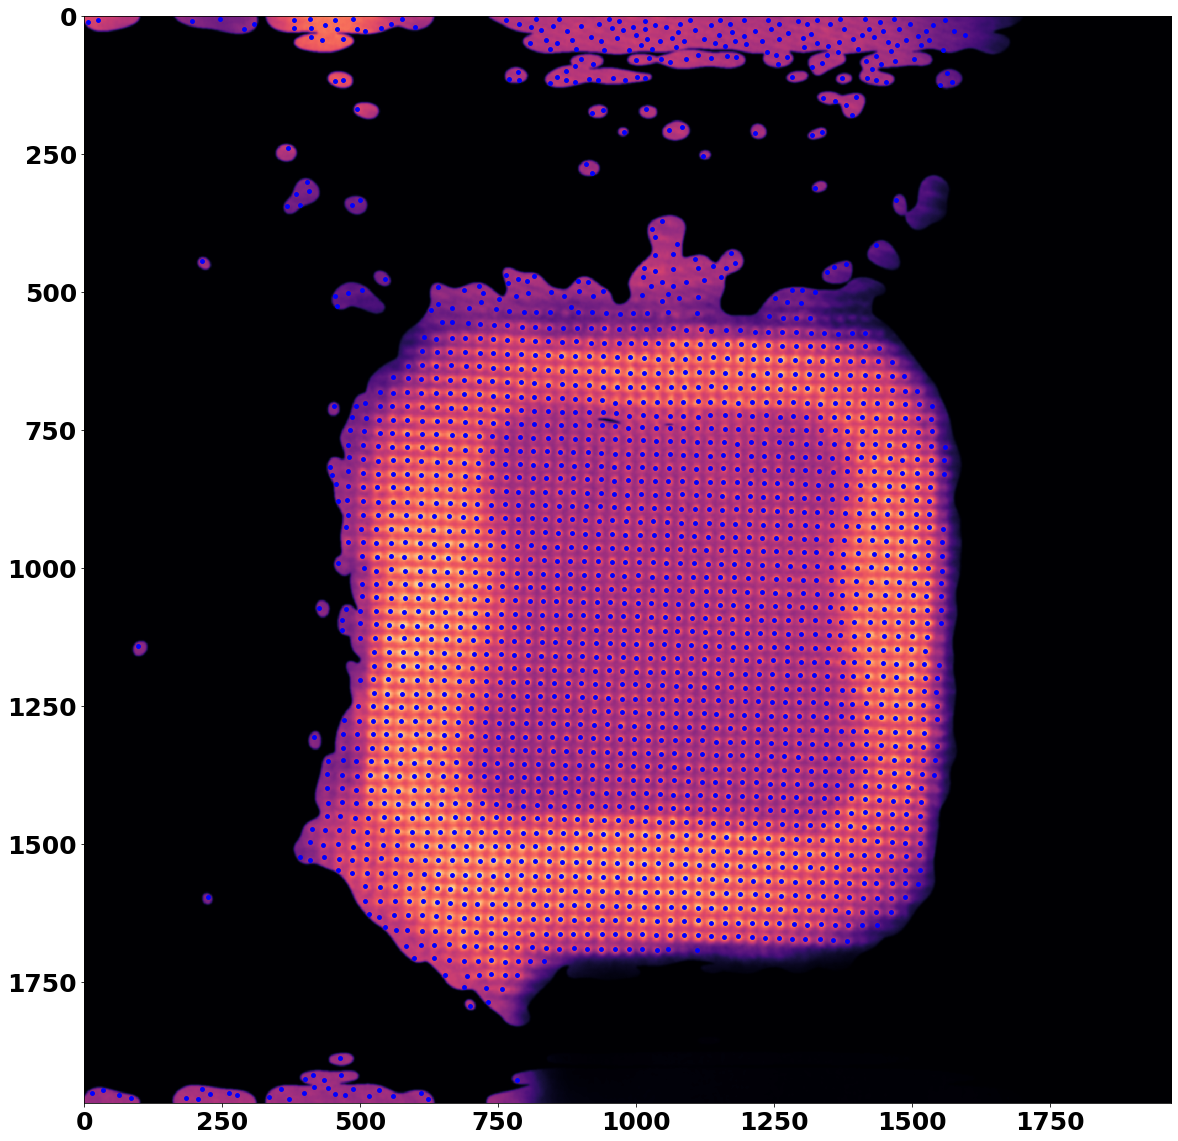

In [11]:
imDC_peaks = st.afit.peaks_vis(scnd.gaussian_filter(imDC_020,2),15,0.3)

We can now delete the edge cases

(-0.5, 1969.5, 1969.5, -0.5)

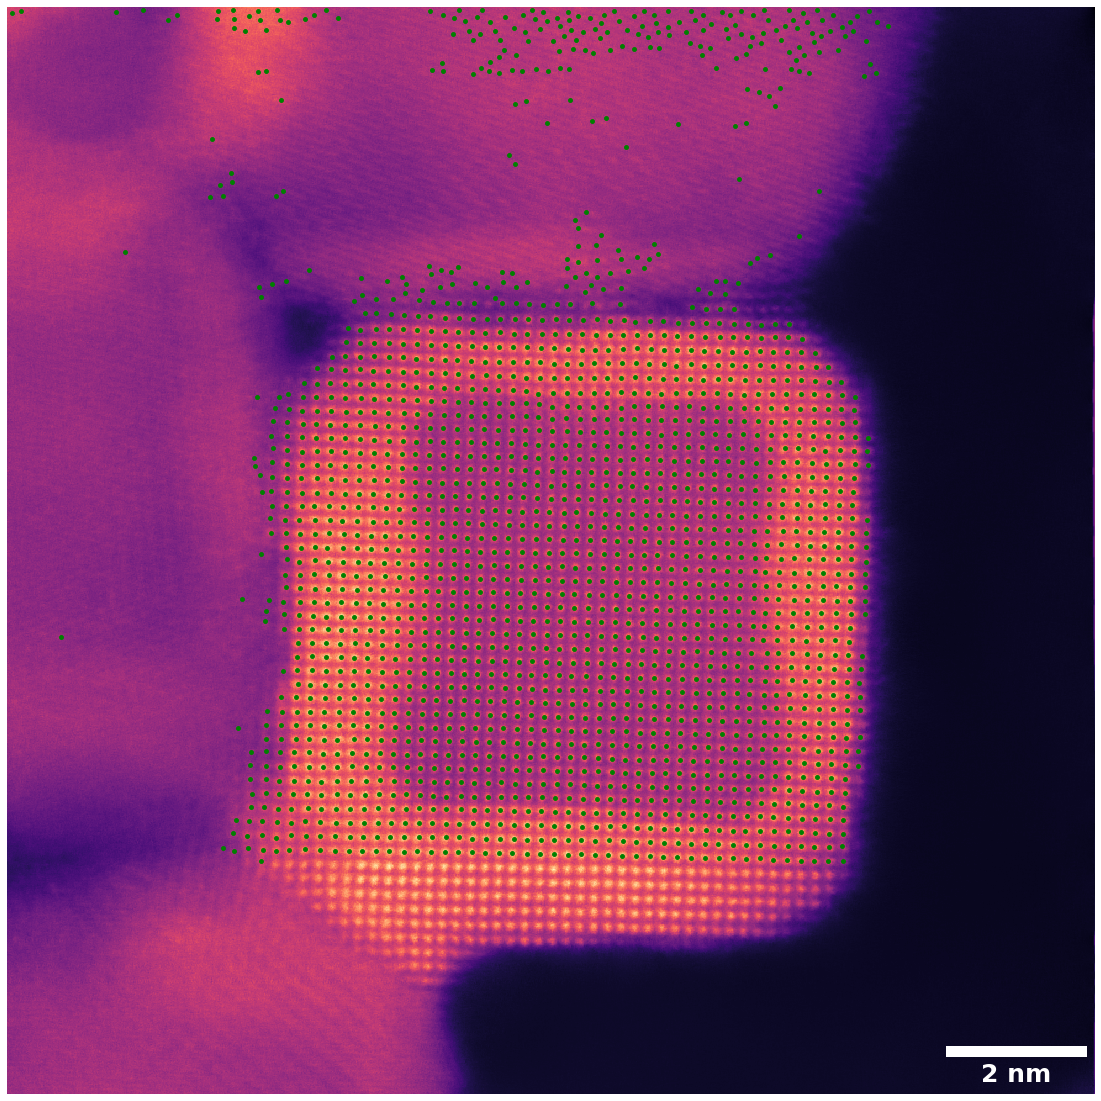

In [12]:
imageDC_peaks = np.copy(imDC_peaks)
imageDC_peaks = imageDC_peaks[imageDC_peaks[:,0] < 1550]
plt.figure(figsize=(20,20))
plt.imshow(imageDC)
plt.scatter(imageDC_peaks[:,1],imageDC_peaks[:,0],c='g', s=15)
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')

In [13]:
imageDC_peaks.shape

(1992, 2)

In [ ]:
st.tic()
imageDC_rpeaks = st.afit.refine_atoms(imageDC,imageDC_peaks)
st.toc()

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.imshow(imageDC)
plt.scatter(imageDC_peaks[:,1],imageDC_peaks[:,0],c='g', s=15)
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(imageDC)
plt.scatter(imageDC_rpeaks[:,1],imageDC_rpeaks[:,0],c='b', s=15)
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(imageDC)
plt.scatter(imageDC_peaks[:,1],imageDC_peaks[:,0],c='g', s=30)
plt.scatter(imageDC_rpeaks[:,1],imageDC_rpeaks[:,0],c='b', s=10)
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()

In [ ]:
font = {'weight' : 'bold',
        'size'   : 15}

mpl.rc('font', **font)
plt.figure(figsize=(15,15))
plt.imshow(imageDC)
plt.scatter(imageDC_rpeaks[:,1],imageDC_rpeaks[:,0],c='b', s=10)
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()

In [ ]:
st.tic()
imageDC_coords = st.afit.find_coords(imageDC,centerDC_000,centerDC_200,centerDC_020,np.asarray((1,0,0)),np.asarray((0,1,0)))
st.toc()

In [ ]:
imageDC_coords

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(imageDC)
plt.scatter(imageDC.shape[1]/2,imageDC.shape[0]/2,c='r', s=50)
plt.scatter(imageDC.shape[1]/2 + imageDC_coords[0,1],imageDC.shape[0]/2 + imageDC_coords[0,0],c='g', s=50)
plt.scatter(imageDC.shape[1]/2 + imageDC_coords[1,1],imageDC.shape[0]/2 + imageDC_coords[1,0],c='b', s=50)

In [ ]:
axisDC_origin = st.afit.get_origin(imageDC,imageDC_rpeaks,imageDC_coords)

In [ ]:
st.tic()
imageDC_neigh, imageDC_ndist = st.afit.three_neighbors(imageDC_rpeaks,imageDC_coords,0.33)
st.toc()

In [ ]:
st.tic()
imageDC_centers, imageDC_yy,imageDC_xx,imageDC_xy,imageDC_th = st.afit.relative_strain(imageDC_neigh,imageDC_coords)
st.toc()

In [ ]:
imageDC_yy = imageDC_yy - np.median(imageDC_yy)
imageDC_xx = imageDC_xx - np.median(imageDC_xx)
imageDC_xy = imageDC_xy - np.median(imageDC_xy)
imageDC_th = imageDC_th - np.median(imageDC_th)

In [ ]:
st.tic()
strainDC_yy,strainDC_xx,strainDC_xy,strainDC_th = st.afit.strain_map(imageDC_centers,
                                                                     imageDC_yy,
                                                                     imageDC_xx, 
                                                                     imageDC_xy,
                                                                     imageDC_th,
                                                                     maskDC_200)
st.toc()

In [ ]:
vm = 100*np.amax(np.abs(np.concatenate((strainDC_yy,strainDC_xx,strainDC_xy,strainDC_th),axis=1)))
font_size = int(26)
sc_font={'weight' : 'bold',
         'size'   : font_size}
mpl.rc('font', **sc_font)
title_font = {'weight': 'bold',
              'size': int(1.2*font_size),
             }

fig =plt.figure(figsize=(26,13))

gs = mpgs.GridSpec(2, 4)
ax1 = plt.subplot(gs[:, 0:2])
ax2 = plt.subplot(gs[0, 2])
ax3 = plt.subplot(gs[0, 3])
ax4 = plt.subplot(gs[1, 2])
ax5 = plt.subplot(gs[1, 3])

ax1.imshow(imageDC)
ax1.scatter(imageDC_rpeaks[:,1],imageDC_rpeaks[:,0],c='aqua',edgecolors='b',s=35,label='Fitted atoms')
ax1.legend(loc='upper left',markerscale=3,framealpha=1)
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'w'
ax1.add_artist(scalebar)
ax1.set_title(label='a',loc='left',fontdict=title_font)
ax1.axis('off')

im = ax2.imshow(100*strainDC_xx,vmin=-vm, vmax=vm,cmap='RdBu_r')
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'k'
ax2.add_artist(scalebar)
at = AnchoredText(r'$\mathrm{\epsilon_{xx}}$',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
ax2.set_title(label='b',loc='left',fontdict=title_font)
ax2.axis('off')


im = ax3.imshow(100*strainDC_xy,vmin=-vm, vmax=vm,cmap='RdBu_r')
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'k'
ax3.add_artist(scalebar)
at = AnchoredText(r'$\mathrm{\epsilon_{xy}}$',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
ax3.set_title(label='c',loc='left',fontdict=title_font)
ax3.axis('off')


im = ax4.imshow(100*strainDC_th,vmin=-vm, vmax=vm,cmap='RdBu_r')
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'k'
ax4.add_artist(scalebar)
at = AnchoredText(r'$\mathrm{\epsilon_{\theta}}$',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax4.add_artist(at)
ax4.set_title(label='d',loc='left',fontdict=title_font)
ax4.axis('off')


im = ax5.imshow(100*strainDC_yy,vmin=-vm, vmax=vm,cmap='RdBu_r')
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 0
scalebar.color = 'k'
ax5.add_artist(scalebar)
at = AnchoredText(r'$\mathrm{\epsilon_{yy}}$',
                  prop=dict(size=font_size), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax5.add_artist(at)
ax5.set_title(label='e',loc='left',fontdict=title_font)
ax5.axis('off')

p4 = ax4.get_position().get_points().flatten()
p5 = ax5.get_position().get_points().flatten()

ax_cbar = fig.add_axes([p4[0] - 0.005, -0.01, 0.5*p5[2], 0.02])
cbar = plt.colorbar(im, cax=ax_cbar, orientation='horizontal')
cbar.set_label('Strain (%)',**sc_font)

plt.tight_layout()